In [1]:
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import scipy.optimize as opt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor

In [2]:
Exptdata = np.load(
    "/home2/hky/github/Gamma_Energy/Exptdata/J1857Cut_23_05_14/cutedData_E_RaDec.npz"
)
Exptdata = {key: Exptdata[key] for key in Exptdata}


In [5]:
Exptdata["sumpf"] = np.log10(Exptdata["sumpf"])

In [3]:
import healpy as hp
NSIDE = 2**9

In [65]:
def getwindowssize_point(sumpf, need, minsize, maxsize):
    windowssize = 6.91 / np.sqrt(10 ** sumpf[need])
    windowssize[windowssize < minsize] = minsize
    windowssize[windowssize > maxsize] = maxsize
    return windowssize


def getwindowssize_expand(sumpf, need, minsize, maxsize):
    windowssize = np.sqrt(47.6 / 10 ** sumpf[need] + 2.5 * 0.28**2)
    windowssize[windowssize < minsize] = minsize
    windowssize[windowssize > maxsize] = maxsize
    return windowssize


def getwindowssize_fixed(sumpf, need, minsize, maxsize):
    windowssize = np.full_like(sumpf[need], minsize)
    return windowssize


def getwindowssize(sumpf, need, minsize, maxsize, method):
    windowssize = list()
    if method == "point":
        for minsize_i in minsize:
            windowssize.append(getwindowssize_point(sumpf, need, minsize_i, maxsize))
    elif method == "expand":
        for minsize_i in minsize:
            windowssize.append(getwindowssize_expand(sumpf, need, minsize_i, maxsize))
    elif method == "fixed":
        for minsize_i in minsize:
            windowssize.append(getwindowssize_fixed(sumpf, need, minsize_i, maxsize))
    return windowssize


def LIMA(alpha, Non, Noff):
    sig = np.sqrt(2) * np.sqrt(
        Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
        + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
    )
    if type(sig) is np.ndarray:
        sig[np.where((Non - Noff * alpha) < 0)] = -sig[
            np.where((Non - Noff * alpha) < 0)
        ]
    else:
        if (Non - Noff * alpha) < 0:
            sig = -sig
    return sig


def twoPointAngle(theta1, theta2, phi1, phi2):
    return np.rad2deg(
        np.arccos(
            np.sin(np.deg2rad(theta1))
            * np.sin(np.deg2rad(theta2))
            * np.cos(np.deg2rad(phi1 - phi2))
            + np.cos(np.deg2rad(theta1)) * np.cos(np.deg2rad(theta2))
        )
    )


def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta) ** 2) / (2 * sigma_x**2) + (np.sin(theta) ** 2) / (
        2 * sigma_y**2
    )
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (
        4 * sigma_y**2
    )
    c = (np.sin(theta) ** 2) / (2 * sigma_x**2) + (np.cos(theta) ** 2) / (
        2 * sigma_y**2
    )
    g = offset + amplitude * np.exp(
        -(a * ((x - xo) ** 2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo) ** 2))
    )
    return g.ravel()


def twoD_gaussian_r(distance, sigma):
    return np.exp(-(distance**2) / 2 / sigma**2)


def GetAllBackground(
    Exptdata,
    Energymin,
    Ra,
    Ra_gap,
    Ra_bins,
    Dec,
    Dec_gap,
    Dec_bins,
    angle,
    method,
):
    Ra_min = Ra - Ra_gap * Ra_bins / 2
    Ra_max = Ra + Ra_gap * Ra_bins / 2
    Dec_min = Dec - Dec_gap * Dec_bins / 2
    Dec_max = Dec + Dec_gap * Dec_bins / 2
    x_binscount = int(np.round((Ra_max - Ra_min) / Ra_gap)) + 1
    y_binscount = int(np.round((Dec_max - Dec_min) / Dec_gap)) + 1
    x_bins = np.linspace(Ra_min, Ra_max, x_binscount)
    y_bins = np.linspace(Dec_min, Dec_max, y_binscount)
    x = (x_bins[:-1] + x_bins[1:]) / 2
    y = (y_bins[:-1] + y_bins[1:]) / 2

    ALL = np.zeros([len(x), len(y), len(angle)])
    Background = np.zeros([len(x), len(y), len(angle)])
    Dec_outer = 2
    Ra_outer = 2 * np.rad2deg(
        np.arcsin(
            np.sin(np.deg2rad(Dec_outer / 2))
            / np.cos(np.deg2rad(np.max(np.abs([Dec_min, Dec_max]))))
        )
    )
    index_energy_cut = np.where(
        (Exptdata[f"energy"] > Energymin)
        & (Exptdata[f"Dec"] > Dec_min - Dec_outer)
        & (Exptdata[f"Dec"] < Dec_max + Dec_outer)
        & (Exptdata[f"Ra"] > Ra_min - Ra_outer)
        & (Exptdata[f"Ra"] < Ra_max + Ra_outer)
    )
    windowssize = getwindowssize(Exptdata["sumpf"], index_energy_cut, angle, 1, method)
    for i in range(x_binscount - 1):
        for j in range(y_binscount - 1):
            distance = twoPointAngle(
                90 - Exptdata[f"Dec"][index_energy_cut],
                90 - y[j],
                Exptdata[f"Ra"][index_energy_cut],
                x[i],
            )
            for minsize_i in range(len(angle)):
                if method == "gauss":
                    ALL[i, j, minsize_i] = np.sum(
                        twoD_gaussian_r(distance, angle[minsize_i])
                    )
                else:
                    ALL[i, j, minsize_i] = np.sum(distance < windowssize[minsize_i])

    for k in range(20):
        index_energy_cut = np.where(
            (Exptdata[f"energy"] > Energymin)
            & (Exptdata[f"DecOff_{k}"] > Dec_min - Dec_outer)
            & (Exptdata[f"DecOff_{k}"] < Dec_max + Dec_outer)
            & (Exptdata[f"RaOff_{k}"] > Ra_min - Ra_outer)
            & (Exptdata[f"RaOff_{k}"] < Ra_max + Ra_outer)
        )
        windowssize = getwindowssize(
            Exptdata["sumpf"], index_energy_cut, angle, 1, method
        )

        for i in range(x_binscount - 1):
            for j in range(y_binscount - 1):
                distance = twoPointAngle(
                    90 - Exptdata[f"DecOff_{k}"][index_energy_cut],
                    90 - y[j],
                    Exptdata[f"RaOff_{k}"][index_energy_cut],
                    x[i],
                )
                for minsize_i in range(len(angle)):
                    if method == "gauss":
                        Background[i, j, minsize_i] += np.sum(
                            twoD_gaussian_r(distance, angle[minsize_i])
                        )
                    else:
                        Background[i, j, minsize_i] += np.sum(
                            distance < windowssize[minsize_i]
                        )
    print(f"=====finish=======Ra={Ra}")
    return x, y, ALL, Background


In [66]:
Ra = 284.5
Ra_gap = 0.05
Ra_bins = 80
Dec = 2.5
Dec_gap = 0.05
Dec_bins = 80

In [67]:
angle = [0.5, 0.8, 1, 1.5, 2]

In [68]:
windowstype = "fixed"

In [74]:
Energymin=20

In [75]:
x, y, ALL, Background = GetAllBackground(
                Exptdata,
                Energymin,
                Ra,
                Ra_gap,
                Ra_bins,
                Dec,
                Dec_gap,
                Dec_bins,
                angle,
                windowstype,
            )

=====finish=======Ra=284.5


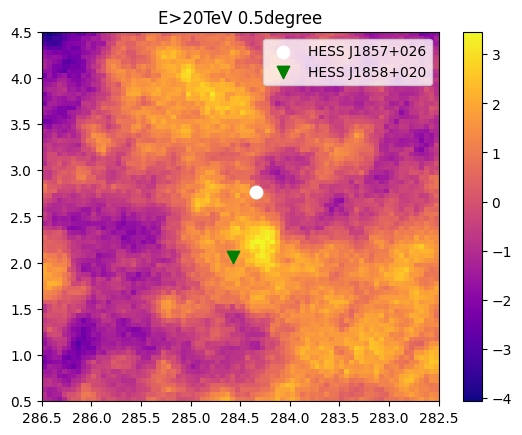

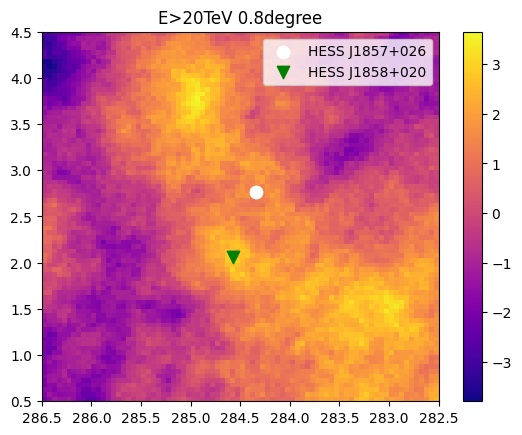

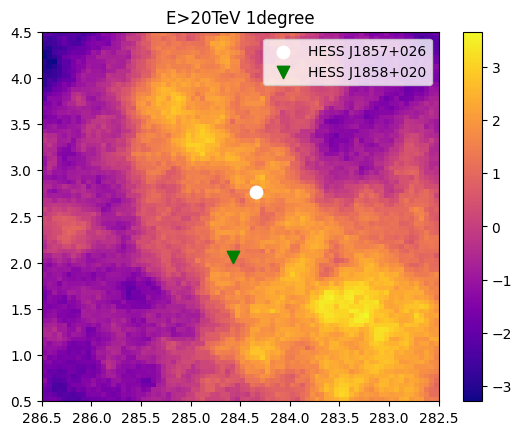

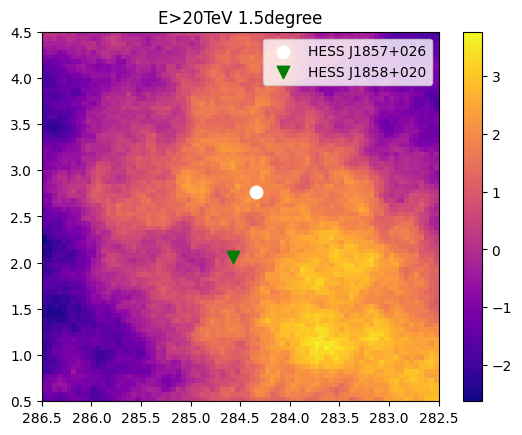

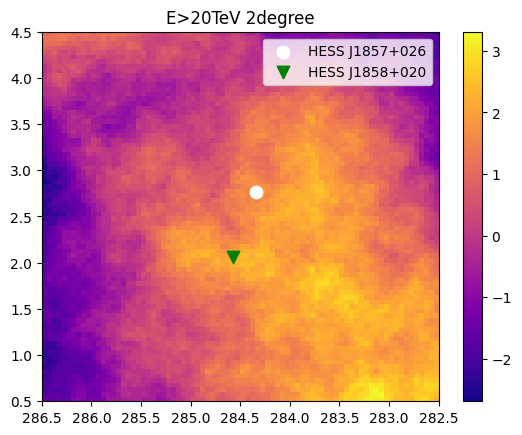

: 

In [76]:
for i,angle_tmp in enumerate(angle):
    ALL_tmp = ALL[:, :, i].T
    Background_tmp = Background[:, :, i].T
    for i in range(Background_tmp.shape[0]):
        Background_tmp[i] = np.mean(Background_tmp[i])
    fig,ax = plt.subplots()
    sig = LIMA(0.05, ALL_tmp, Background_tmp)
    sig[np.isnan(sig)] = 0
    c = ax.pcolormesh(
        x, y, sig, cmap="plasma"
    )
    ax.scatter(
                        284.34,
                        2.76,
                        c="white",
                        marker="o",
                        label="HESS J1857+026",
                        s=80,
                    )
    ax.scatter(
                        284.57,
                        2.06,
                        c="g",
                        marker="v",
                        label="HESS J1858+020",
                        s=80,
                    )
    ax.legend()
    plt.colorbar(c, orientation="vertical")
    ax.invert_xaxis()
    plt.title(f"E>{Energymin}TeV {angle_tmp}degree")
    plt.show()

In [78]:
Crab = np.load("/home2/hky/github/Gamma_Energy/Exptdata/mergedData_eqzenith_mdcut.npz")

In [96]:
nearCrabcut = np.where((Crab["Dec"]<22.5)&(Crab["Dec"]>21.5)&(Crab["isgamma"]==1))
equRaCrabcut = np.where((Crab["Dec"]<22.5)&(Crab["Dec"]>21.5)&(Crab["isgamma"]==0))
nearCrab = {key:Crab[key][nearCrabcut] for key in Crab}
equRaCrab = {key:Crab[key][equRaCrabcut] for key in Crab}

In [101]:
nearCrab["summd"][nearCrab["summd"]==0]=10**-0.8
equRaCrab["summd"][equRaCrab["summd"]==0]=10**-0.8

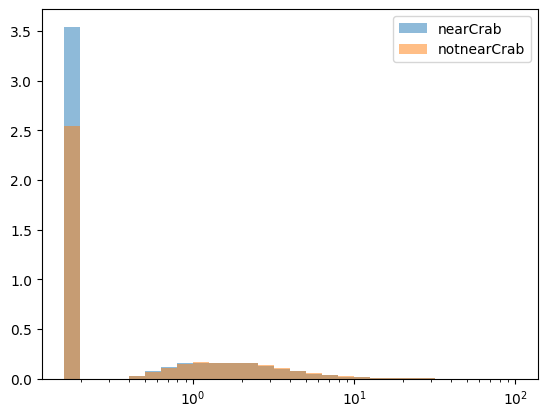

In [110]:
plt.hist(nearCrab["summd"],bins=np.logspace(-0.8,2,29),label="nearCrab",density=True,alpha=0.5)
plt.hist(equRaCrab["summd"],bins=np.logspace(-0.8,2,29),label="notnearCrab",density=True,alpha=0.5)
plt.legend()
plt.xscale("log")
plt.show()

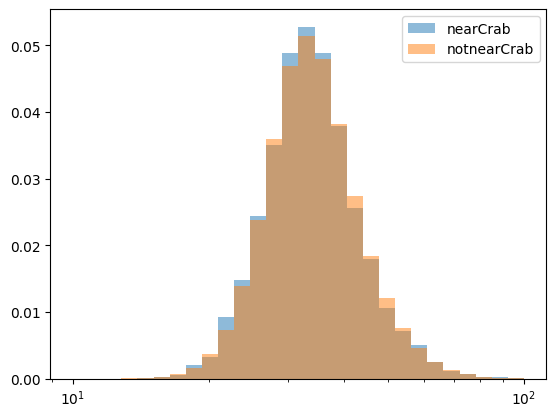

In [107]:
plt.hist(nearCrab["mr1"],bins=np.logspace(1,2,29),label="nearCrab",density=True,alpha=0.5)
plt.hist(equRaCrab["mr1"],bins=np.logspace(1,2,29),label="notnearCrab",density=True,alpha=0.5)
plt.legend()
plt.xscale("log")
plt.show()

In [ ]:
plt.hist(equRaCrab["summd"])


In [80]:
for i in Crab:
    print(i)

runno
evno
mode
mjd
nch
oldtrig
theta
phi
evenodd
sigma
cx
cy
sumpf
summd
mr1
ne
age
ndf
chi2
Ra
Dec
ha
LST
S50
summdnew
isgamma


In [86]:
np.min(Crab["Dec"][(Crab["Dec"]<25)&(Crab["Dec"]>20)])

21.50000002468374

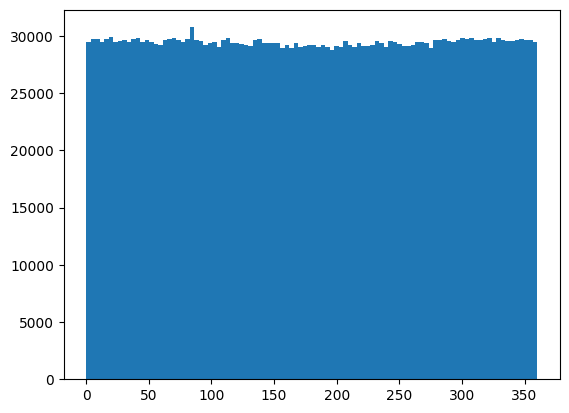

In [90]:
plt.hist(Crab["Ra"][(Crab["Dec"]<22.5)&(Crab["Dec"]>21.5)],bins=100)
plt.show()

In [2]:
data = np.load(
    "/home2/hky/github/Gamma_Energy/Exptdata/mergedData_eqzenith_mdcut.npz"
)
data = {key: data[key] for key in data}

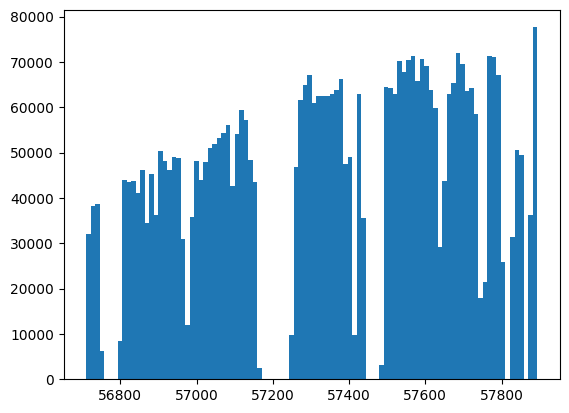

In [4]:
plt.hist(data["mjd"],bins=100)
plt.show()

In [72]:
def LIMA(alpha, Non, Noff):
    sig = np.sqrt(2) * np.sqrt(
        Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
        + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
    )
    if type(sig) is np.ndarray:
        sig[np.where((Non - Noff * alpha) < 0)] = -sig[
            np.where((Non - Noff * alpha) < 0)
        ]
    else:
        if (Non - Noff * alpha) < 0:
            sig = -sig
    sig[np.isnan(sig)]=0
    return sig

In [3]:
para_num=5
predictor_gamma_CR_sectheta = TabularPredictor.load(
    f"/home2/hky/github/Gamma_Energy/AllSky_withCR/agmodel/identitfy_gamma_CR_Allsky_MC_{para_num}par_likeExpt_sectheta/"
)
predictor_gamma_CR = TabularPredictor.load(
    f"/home2/hky/github/Gamma_Energy/AllSky_withCR/agmodel/identitfy_gamma_CR_Allsky_MC_5par_likeExpt_random_abscxcy"
)

In [11]:
test_data = np.load("/home2/hky/github/Gamma_Energy/AllSky_withCR/Data/Datawithe_Galactic_2000_withMC_test_random.npz")

In [12]:
columns_need = [
    "theta",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "prie",
    "isgamma",
]
test_data = pd.DataFrame({key: test_data[key] for key in columns_need})
test_data["sectheta"]=1/np.cos(np.deg2rad(test_data["theta"]))


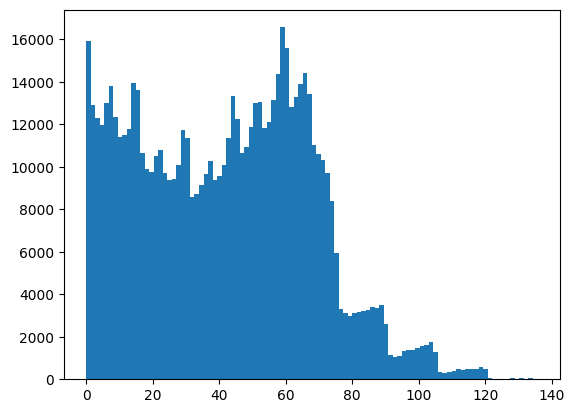

In [17]:
plt.hist(np.abs(test_data["cx"][test_data["isgamma"]==0]),bins=100)
plt.show()

In [54]:
np.sum(np.abs(test_data["cx"][test_data["isgamma"]==0])<70)/np.sum(test_data["isgamma"]==0)

0.8666073918115345

In [55]:
np.sum(np.abs(test_data["cx"][test_data["isgamma"]==1])<70)/np.sum(test_data["isgamma"]==1)

0.7875729149523653

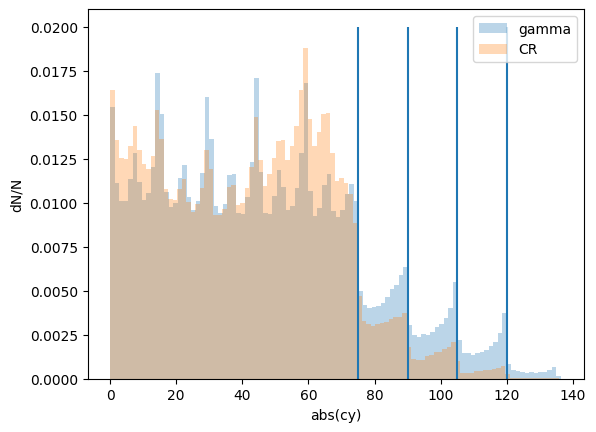

In [67]:
plt.hist(np.abs(test_data["cy"][test_data["isgamma"]==1]),bins=100,alpha=0.3,label="gamma",density=True)
plt.hist(np.abs(test_data["cy"][test_data["isgamma"]==0]),bins=100,alpha=0.3,label="CR",density=True)
plt.vlines([75,90,105,120],0,0.02)
plt.legend()
plt.xlabel("abs(cy)")
plt.ylabel("dN/N")
plt.show()

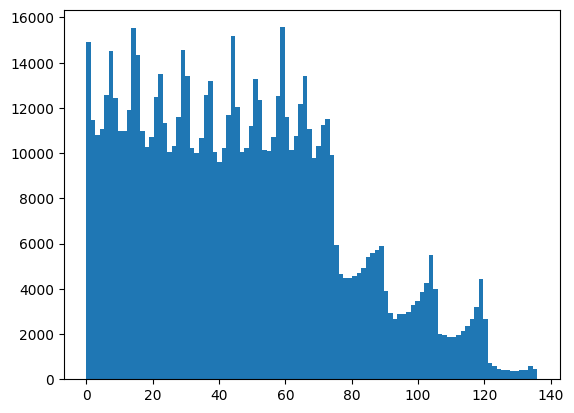

In [29]:
plt.hist(np.abs(test_data["cy"][(test_data["isgamma"]==1)&(np.abs(test_data["cx"])<70)]),bins=100)
plt.show()

(array([1.07980e+04, 2.07174e+05, 3.03704e+05, 1.24851e+05, 3.97470e+04,
        1.18760e+04, 3.60000e+03, 9.69000e+02, 2.04000e+02, 1.70000e+01]),
 array([1.53468088, 1.8240539 , 2.11342693, 2.40279995, 2.69217297,
        2.98154599, 3.27091901, 3.56029203, 3.84966505, 4.13903807,
        4.42841109]),
 <BarContainer object of 10 artists>)

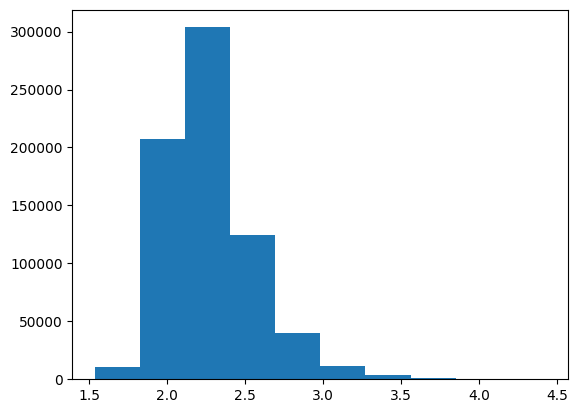

In [13]:
plt.hist(np.log10(test_data["sumpf"][test_data["isgamma"]==0]))

(array([ 22384., 270462., 308053., 181022., 100632.,  54206.,  27393.,
         13227.,   5543.,   1705.]),
 array([1.55955784, 1.87674774, 2.19393765, 2.51112755, 2.82831746,
        3.14550737, 3.46269727, 3.77988718, 4.09707709, 4.41426699,
        4.7314569 ]),
 <BarContainer object of 10 artists>)

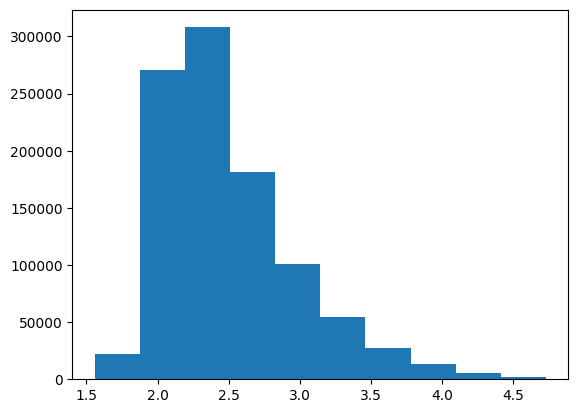

In [43]:
plt.hist(np.log10(test_data["sumpf"][test_data["isgamma"]==1]))

(array([  2674., 111354., 343821., 296935., 149949.,  55089.,  17195.,
          5352.,   1750.,    508.]),
 array([0.08662673, 0.57780624, 1.06898575, 1.56016525, 2.05134476,
        2.54252426, 3.03370377, 3.52488328, 4.01606278, 4.50724229,
        4.99842179]),
 <BarContainer object of 10 artists>)

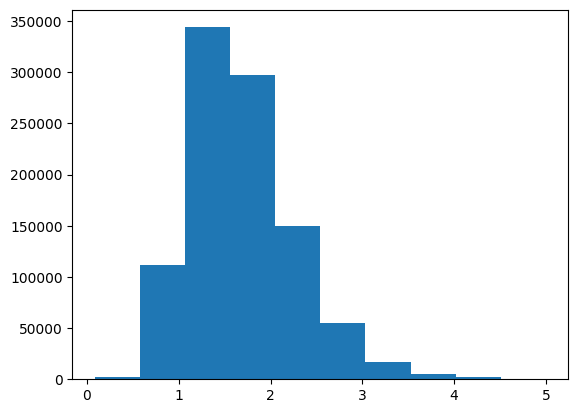

In [55]:
plt.hist(np.log10(test_data["prie"][test_data["isgamma"]==1])-3)

In [44]:
predictor_gamma_CR.feature_importance(test_data)

These features in provided data are not utilized by the predictor and will be ignored: ['prie', 'sectheta']


,importance,stddev,p_value,n,p99_high,p99_low
summd,0.295336,0.010660,2.033474e-07,5,0.317286,0.273387
sumpf,0.213539,0.010147,6.100566e-07,5,0.234432,0.192645
cy,0.017227,0.002287,3.642751e-05,5,0.021936,0.012517
cx,0.015038,0.002286,6.215232e-05,5,0.019745,0.010331
theta,0.008407,0.001648,1.686339e-04,5,0.011800,0.005013


In [35]:
cx = np.linspace(0,100,401)
cy = np.linspace(0,100,401)
x,y=np.meshgrid(cx,cy)

In [47]:
x_=x.reshape(-1)
y_=y.reshape(-1)
theta_val = 30
summd_val = 2
sumpf_val = (summd_val/2.1e-3)**(1/1.2)
theta = np.full_like(x_,theta_val)
summd = np.full_like(x_,summd_val)
sumpf = np.full_like(x_,sumpf_val)

In [48]:
sumpf_val

303.628301946383

In [49]:
df = pd.DataFrame({"cx":x_,"cy":y_,"summd":summd,"sumpf":sumpf,"theta":theta})

In [50]:
df["isgamma"]=predictor_gamma_CR.predict_proba(df)[1]

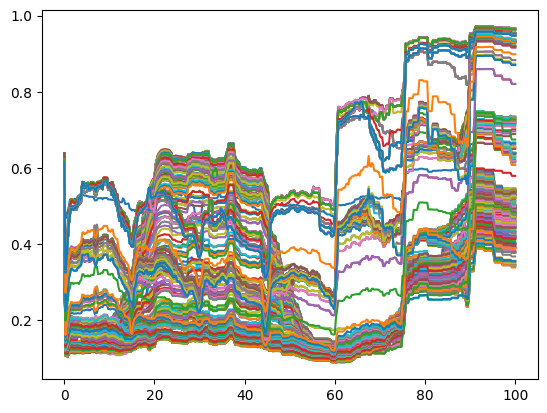

In [51]:
plt.plot(y,df["isgamma"].to_numpy().reshape(x.shape))
plt.show()

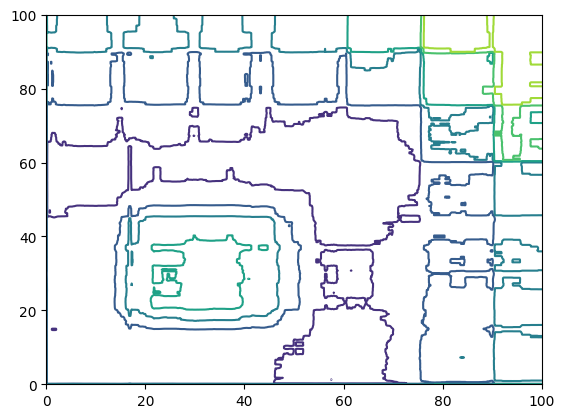

In [52]:
cs=plt.contour(x, y, df["isgamma"].to_numpy().reshape(x.shape))
# plt.clabel(cs,inline=True)
plt.show()


In [9]:
test_data["isgamma_pred"] = predictor_gamma_CR.predict_proba(test_data)[1]

NameError: name 'test_data' is not defined

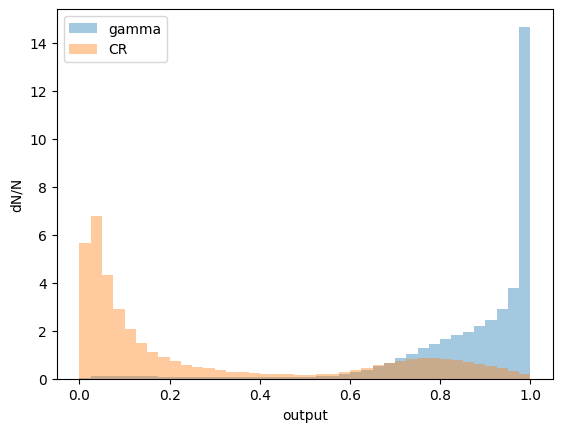

In [46]:
bins = np.linspace(0,1,41)
plt.hist(test_data["isgamma_pred"][test_data["isgamma"] == 1], label="gamma", alpha=0.4,density=True,bins=bins)
plt.hist(test_data["isgamma_pred"][test_data["isgamma"] == 0], label="CR", alpha=0.4,density=True,bins=bins)
plt.legend()
plt.ylabel("dN/N")
plt.xlabel("output")
plt.show()


In [212]:
Pvalue = 0.6
CRrate = np.array([0.01621, 0.01579, 0.01288, 0.00944, 0.00731, 0.00692, 0.00585])
gammarate = np.array([0.9651, 0.9669, 0.9720, 0.9727, 0.9710, 0.9704, 0.9689])
CRrate2 = np.zeros_like(CRrate)
gammarate2 = np.zeros_like(CRrate)
Energymean = np.zeros_like(CRrate)
Energypeak = np.zeros_like(CRrate)
for i,sumpf_min in enumerate([30, 100, 200, 400, 800, 1000, 2000]):
    gamma_count = np.sum(
        (test_data["isgamma"] == 1)
        & (test_data["isgamma_pred"] > Pvalue)
        & (test_data["sumpf"] > sumpf_min)
    )
    CR_count = np.sum(
        (test_data["isgamma"] == 0)
        & (test_data["isgamma_pred"] > Pvalue)
        & (test_data["sumpf"] > sumpf_min)
    )
    gamma_all = np.sum((test_data["isgamma"] == 1) & (test_data["sumpf"] > sumpf_min))
    CR_all = np.sum((test_data["isgamma"] == 0) & (test_data["sumpf"] > sumpf_min))
    CRrate2[i]=CR_count/CR_all
    gammarate2[i]=gamma_count/gamma_all
    prie = np.log10(test_data["prie"][(test_data["isgamma"] == 1)
        & (test_data["isgamma_pred"] > Pvalue)
        & (test_data["sumpf"] > sumpf_min)])
    Energymean[i] = 10**np.mean(prie)
    hist,edge = np.histogram(prie)
    edge_center = (edge[1:]+edge[:-1])/2
    Energypeak[i] = 10**(edge_center[np.argmax(hist)])


In [213]:
sumpfminlist = np.array([30, 100, 200, 400, 800, 1000, 2000])

for i, sumpfmin in enumerate(sumpfminlist):
    print(sumpfminlist[i],f"{Energymean[i]/1000:.1f}",f"{Energypeak[i]/1000:.1f}",f"{CRrate2[i]*100:.3f}",f"{CRrate2[i]*CRrate[i]*100:.3f}",f"{(1-CRrate2[i]*CRrate[i])*100:.3f}",f"{gammarate2[i]*100:.3f}",f"{gammarate2[i]*gammarate[i]*100:.3f}")


30 50.2 23.0 24.472 0.397 99.603 94.522 91.223
100 55.3 25.9 20.662 0.326 99.674 94.864 91.724
200 86.6 88.3 11.909 0.153 99.847 95.467 92.794
400 153.6 86.9 11.011 0.104 99.896 97.846 95.175
800 284.1 172.0 9.839 0.072 99.928 99.009 96.138
1000 349.9 206.0 9.753 0.067 99.933 99.159 96.224
2000 699.6 448.1 11.371 0.067 99.933 99.483 96.389


In [ ]:
sumpfminlist = np.array([30, 100, 200, 400, 800, 1000, 2000])

for i, sumpfmin in enumerate(sumpfminlist):
    print(sumpfminlist[i],f"{Energymean[i]/1000:.1f}",f"{Energypeak[i]/1000:.1f}",f"{CRrate2[i]*100:.3f}",f"{CRrate2[i]*CRrate[i]*100:.3f}",f"{(1-CRrate2[i]*CRrate[i])*100:.3f}",f"{gammarate2[i]*100:.3f}",f"{gammarate2[i]*gammarate[i]*100:.3f}")


In [ ]:
print(f"{gamma_count/gamma_all*100:.2f}%", f"{CRrate*(CR_count/CR_all)*100:.2f}%")


In [57]:
10**np.mean(np.log10(test_data["prie"][test_data["isgamma"]==1])-3)

49.08144770071532

In [65]:
Pvalue=0.7
10**np.mean(np.log10(test_data["prie"][(test_data["isgamma"] == 1)&(test_data["isgamma_pred"] >Pvalue)])-3)

53.486724339663716

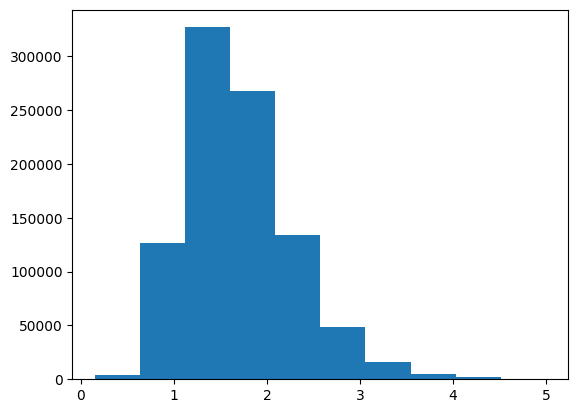

In [53]:
Pvalue=0.6
plt.hist(np.log10(test_data["prie"][(test_data["isgamma"] == 1)&(test_data["isgamma_pred"] >Pvalue)])-3)
plt.show()

(array([ 1934., 10826.,  6515.,  3154.,  2955.,  2385.,  2326.,  2081.,
         4872.,  3353.]),
 array([0.12036907, 0.19248311, 0.26459716, 0.3367112 , 0.40882525,
        0.4809393 , 0.55305334, 0.62516739, 0.69728143, 0.76939548,
        0.84150952]),
 <BarContainer object of 10 artists>)

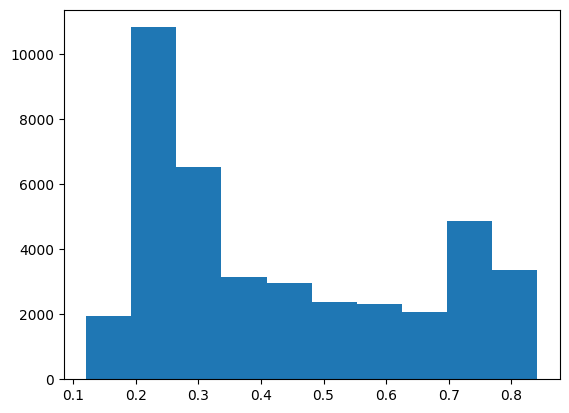

In [14]:
plt.hist(df["isgamma"])

In [7]:
Exptdata = np.load(
    "/home2/hky/github/Gamma_Energy/Exptdata/CrabCut_23_05_07_summdcut/cutedData_E_isgamma_RaDec.npz"
)
Exptdata = {key: Exptdata[key]for key in Exptdata}

In [9]:
Exptdata[f"isgamma_{para_num}_useMC"] =predictor_gamma_CR.predict_proba(pd.DataFrame(Exptdata))[1].to_numpy()

In [95]:
np.savez("/home2/hky/github/Gamma_Energy/Exptdata/CrabCut_23_05_07_summdcut/cutedData_E_isgamma_RaDec.npz", **Exptdata)

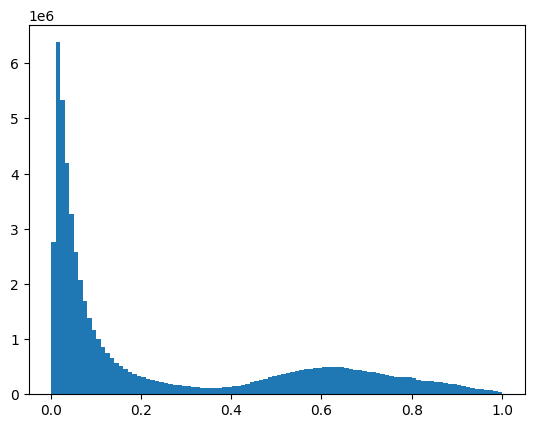

In [10]:
para_num=5
plt.hist(Exptdata[f"isgamma_{para_num}_useMC"],bins=100)
# plt.yscale("log")
plt.show()

In [11]:
def twoPointAngle(theta1, theta2, phi1, phi2):
    return np.rad2deg(
        np.arccos(
            np.sin(np.deg2rad(theta1))
            * np.sin(np.deg2rad(theta2))
            * np.cos(np.deg2rad(phi1 - phi2))
            + np.cos(np.deg2rad(theta1)) * np.cos(np.deg2rad(theta2))
        )
    )
def LIMA(alpha, Non, Noff):
    sig = np.sqrt(2) * np.sqrt(
        Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
        + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
    )
    if type(sig) is np.ndarray:
        sig[np.where((Non - Noff * alpha) < 0)] = -sig[
            np.where((Non - Noff * alpha) < 0)
        ]
    else:
        if (Non - Noff * alpha) < 0:
            sig = -sig
    return sig

In [12]:
from tabulate import tabulate
headers=["cut","Energy_min","Energy_max","On","alpha*Off","Over","sigma"]

In [13]:
CrabMC = np.load("/home2/hky/github/Gamma_Energy/MCdata/CrabMCData.npz")
CrabMCneed = np.where(((CrabMC["summd"]<0.4)|(CrabMC["summd"]<5.1e-3*CrabMC["sumpf"]**1.2))&(CrabMC["inout"]==1)&(CrabMC["sigma"]<1)&(CrabMC["nch"]>=16)&(CrabMC["theta"]<60)&(CrabMC["S50"]>10**-1.2))
CrabMC ={key:CrabMC[key][CrabMCneed] for key in CrabMC}
Crabpri = np.load("/home2/hky/github/Gamma_Energy/MCdata/priEvent.npy")

In [14]:
CrabMC["distance"] = twoPointAngle(CrabMC["theta"],CrabMC["pritheta"],CrabMC["phi"],CrabMC["priphi"])

In [15]:
predictor_energy = TabularPredictor.load(
    "/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=0/log10Energy"
)

CrabMC["sumpf"] = np.log10(CrabMC["sumpf"])
CrabMC["energy"] = 10**predictor_energy.predict(pd.DataFrame(CrabMC)).to_numpy()
CrabMC["sumpf"] = 10**CrabMC["sumpf"]
CrabMC[f"isgamma_{para_num}_useMC"] =predictor_gamma_CR.predict_proba(pd.DataFrame(CrabMC))[1].to_numpy()

In [16]:
Crabpri[-4] = Crabpri[-4]+Crabpri[-3]
Crabpri[-3] = Crabpri[-2]+Crabpri[-1]
Crabpri=Crabpri[:-2]

10TeV以上显著性: 17.66
25TeV以上显著性: 10.95
100TeV以上显著性: 5.04
+-------+--------------+--------------+--------+-------------+--------+---------+
|   cut |   Energy_min |   Energy_max |     On |   alpha*Off |   Over |   sigma |
+=======+==============+==============+========+=============+========+=========+
|  0.60 |        10.00 |        15.85 | 240.00 |      142.25 |  97.75 |    7.24 |
+-------+--------------+--------------+--------+-------------+--------+---------+
|  0.60 |        15.85 |        25.12 | 237.00 |      122.35 | 114.65 |    8.89 |
+-------+--------------+--------------+--------+-------------+--------+---------+
|  0.60 |        25.12 |        39.81 | 163.00 |       66.60 |  96.40 |    9.62 |
+-------+--------------+--------------+--------+-------------+--------+---------+
|  0.60 |        39.81 |        63.10 |  68.00 |       27.55 |  40.45 |    6.26 |
+-------+--------------+--------------+--------+-------------+--------+---------+
|  0.60 |        63.10 |       100.00 |  50.

/tmp/ipykernel_2440587/2172139755.py:12: RuntimeWarning: divide by zero encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2440587/2172139755.py:12: RuntimeWarning: invalid value encountered in double_scalars
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))


10TeV以上显著性: 15.10
25TeV以上显著性: 13.40
100TeV以上显著性: 6.12
+-------+--------------+--------------+-------+-------------+--------+---------+
|   cut |   Energy_min |   Energy_max |    On |   alpha*Off |   Over |   sigma |
+=======+==============+==============+=======+=============+========+=========+
|  0.98 |        10.00 |        15.85 |  0.00 |        0.05 |  -0.05 |  nan    |
+-------+--------------+--------------+-------+-------------+--------+---------+
|  0.98 |        15.85 |        25.12 |  2.00 |        0.30 |   1.70 |    1.94 |
+-------+--------------+--------------+-------+-------------+--------+---------+
|  0.98 |        25.12 |        39.81 | 13.00 |        0.50 |  12.50 |    6.97 |
+-------+--------------+--------------+-------+-------------+--------+---------+
|  0.98 |        39.81 |        63.10 | 17.00 |        0.85 |  16.15 |    7.62 |
+-------+--------------+--------------+-------+-------------+--------+---------+
|  0.98 |        63.10 |       100.00 | 22.00 |        

/tmp/ipykernel_2440587/139471595.py:33: RuntimeWarning: invalid value encountered in divide
  spectrum = (On-Off/20)/dE/176.158 / 24 / 60 / 60  / (30000 * 30000 * 3.1415926)/rate*energybin_center**2
/tmp/ipykernel_2440587/139471595.py:34: RuntimeWarning: invalid value encountered in divide
  spectrumerr = np.sqrt(On+Off/40)/dE/176.158 / 24 / 60 / 60  / (30000 * 30000 * 3.1415926)/rate*energybin_center**2
/tmp/ipykernel_2440587/2172139755.py:12: RuntimeWarning: invalid value encountered in long_scalars
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2440587/2172139755.py:13: RuntimeWarning: invalid value encountered in double_scalars
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))


10TeV以上显著性: 12.02
25TeV以上显著性: 10.87
100TeV以上显著性: 5.22
+-------+--------------+--------------+-------+-------------+--------+---------+
|   cut |   Energy_min |   Energy_max |    On |   alpha*Off |   Over |   sigma |
+=======+==============+==============+=======+=============+========+=========+
|  0.99 |        10.00 |        15.85 |  0.00 |        0.00 |   0.00 |  nan    |
+-------+--------------+--------------+-------+-------------+--------+---------+
|  0.99 |        15.85 |        25.12 |  1.00 |        0.05 |   0.95 |    1.85 |
+-------+--------------+--------------+-------+-------------+--------+---------+
|  0.99 |        25.12 |        39.81 |  5.00 |        0.05 |   4.95 |    5.01 |
+-------+--------------+--------------+-------+-------------+--------+---------+
|  0.99 |        39.81 |        63.10 | 12.00 |        0.45 |  11.55 |    6.73 |
+-------+--------------+--------------+-------+-------------+--------+---------+
|  0.99 |        63.10 |       100.00 | 12.00 |        

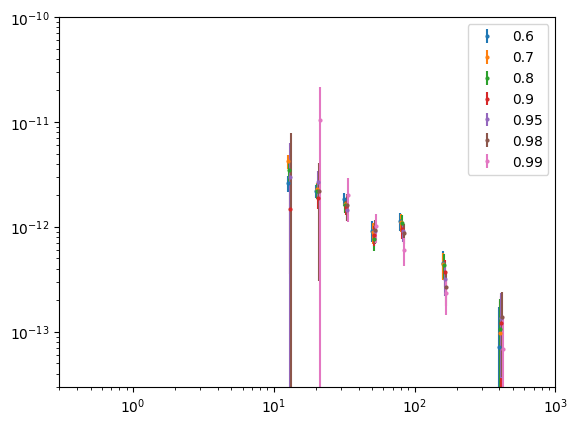

In [17]:
energybin = 10**np.array([1,1.2,1.4,1.6,1.8,2,2.4,2.8])
energybin_center = 10**((np.log10(energybin[1:])+np.log10(energybin[:-1]))/2)
dE = energybin[1:]-energybin[:-1]
count=0
for isgammamin in [0.6,0.7,0.8,0.9,0.95,0.98,0.99]:
    tablelist = list()
    rate = np.zeros(len(energybin)-1)
    for i in range(len(rate)):
        rate[i] = np.sum((CrabMC["energy"]>energybin[i])&(CrabMC["energy"]<energybin[i+1])&((CrabMC["theta"]<40))&(CrabMC["distance"]<0.5)&(CrabMC["isgamma_5_useMC"]>isgammamin))/Crabpri[i]
    Ra = 83.6
    Dec = 22.0
    need = np.where(
        (np.abs(Exptdata["Ra"] - Ra) < 2)
        & (np.abs(Exptdata["Dec"] - Dec) < 2)
        & (Exptdata["theta"]<40)
        & (Exptdata[f"isgamma_{para_num}_useMC"] > isgammamin)
    )
    distance = twoPointAngle(90 - Exptdata["Dec"][need], 90 - Dec, Exptdata["Ra"][need], Ra)
    energy = Exptdata["energy"][need][np.where(distance < 0.5)]
    On, energyedge = np.histogram(energy, bins=energybin)
    Off = np.zeros_like(On)
    for i in range(20):
        need = np.where(
        (np.abs(Exptdata[f"RaOff_{i}"] - Ra) < 2)
        & (np.abs(Exptdata[f"DecOff_{i}"] - Dec) < 2)
        & (Exptdata["theta"]<40)
        & (Exptdata[f"isgamma_{para_num}_useMC"] > isgammamin)
    )
        distance = twoPointAngle(90 - Exptdata[f"DecOff_{i}"][need], 90 - Dec, Exptdata[f"RaOff_{i}"][need], Ra)
        energy = Exptdata["energy"][need][np.where(distance < 0.5)]
        Off_tmp, energyedge = np.histogram(energy, bins=energybin)
        Off+=Off_tmp
    spectrum = (On-Off/20)/dE/176.158 / 24 / 60 / 60  / (30000 * 30000 * 3.1415926)/rate*energybin_center**2
    spectrumerr = np.sqrt(On+Off/40)/dE/176.158 / 24 / 60 / 60  / (30000 * 30000 * 3.1415926)/rate*energybin_center**2
    plt.errorbar(energybin_center*1.01**count,spectrum,spectrumerr,label=isgammamin,fmt='o',markersize=2)
    count += 1
    for i in range(len(energybin)-1):
        tablelist.append([isgammamin,energybin[i],energybin[i+1],On[i],Off[i]/20,On[i]-Off[i]/20,LIMA(0.05,On[i],Off[i])])
    print("10TeV以上显著性:",f"{LIMA(0.05,np.sum(On),np.sum(Off)):.2f}")
    print("25TeV以上显著性:",f"{LIMA(0.05,np.sum(On[3:]),np.sum(Off[3:])):.2f}")
    print("100TeV以上显著性:",f"{LIMA(0.05,np.sum(On[5:]),np.sum(Off[5:])):.2f}")
    print(tabulate(tablelist,headers=headers,tablefmt="grid",floatfmt=".2f"))
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.3,1e3)
plt.ylim(3e-14,1e-10)
plt.show()
    

In [69]:
import healpy as hp
NSIDE = 2**9
NPIX = hp.nside2npix(NSIDE)
Exptdata

In [104]:
isgammaminlist = np.linspace(1,0.4,61)
hpmap_All = np.zeros(NPIX)
hpmap_Background = np.zeros(NPIX)
energymin = 50
data_need = np.where(
    (Exptdata["energy"] > energymin)
    & (Exptdata[f"isgamma_{para_num}_useMC"] > isgammaminlist[0])
)
np.add.at(
    hpmap_All,
    hp.ang2pix(
        NSIDE,
        Exptdata["Ra"][data_need],
        Exptdata["Dec"][data_need],
        lonlat=True,
    ),
    1,
)
for i in range(20):
    np.add.at(
        hpmap_Background,
        hp.ang2pix(
            NSIDE,
            Exptdata[f"RaOff_{i}"][data_need],
            Exptdata[f"DecOff_{i}"][data_need],
            lonlat=True,
        ),
        1,
    )
for isgammamin_i in range(1, len(isgammaminlist)):
    data_need = np.where(
        (Exptdata["energy"] > energymin)
        & (Exptdata[f"isgamma_{para_num}_useMC"] > isgammaminlist[isgammamin_i])
        & (Exptdata[f"isgamma_{para_num}_useMC"] < isgammaminlist[isgammamin_i - 1])
    )
    np.add.at(
        hpmap_All,
        hp.ang2pix(
            NSIDE,
            Exptdata["Ra"][data_need],
            Exptdata["Dec"][data_need],
            lonlat=True,
        ),
        1,
    )
    for i in range(20):
        np.add.at(
            hpmap_Background,
            hp.ang2pix(
                NSIDE,
                Exptdata[f"RaOff_{i}"][data_need],
                Exptdata[f"DecOff_{i}"][data_need],
                lonlat=True,
            ),
            1,
        )
    fwhm = np.deg2rad(0.8)
    hpmap_All_gaus_smoothed = hp.smoothing(hpmap_All, fwhm=fwhm)
    hpmap_background_gaus_smoothed = hp.smoothing(hpmap_Background, fwhm=fwhm)
    sigma = LIMA(0.05, hpmap_All_gaus_smoothed, hpmap_background_gaus_smoothed)
    sigma /= np.std(sigma[hpmap_All != 0])
    print(
        isgammaminlist[isgammamin_i],
        np.max(
            sigma
        ),
    )

# [
#                 hp.query_disc(
#                     NSIDE, hp.ang2vec(284.57, 2.06, lonlat=True), np.deg2rad(1)
#                 )
#             ]

/tmp/ipykernel_2225328/2013940310.py:3: RuntimeWarning: divide by zero encountered in divide
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2225328/2013940310.py:3: RuntimeWarning: invalid value encountered in divide
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2225328/2013940310.py:3: RuntimeWarning: divide by zero encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2225328/2013940310.py:3: RuntimeWarning: invalid value encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2225328/2013940310.py:3: RuntimeWarning: invalid value encountered in multiply
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2225328/2013940310.py:4: RuntimeWarning: divide by zero encountered in divide
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
/tmp/ipykernel_2225328/2013940310.py:4: RuntimeWarning: invalid value encountered in divide
  + Noff 

0.99 15.078223765585108
0.98 14.563810815033305
0.97 14.152836531041988
0.96 13.901553655917542
0.95 13.90004040500245
0.94 13.088583834313562
0.9299999999999999 12.633407760684618
0.92 12.599200203590593
0.91 12.500432495107674
0.9 12.573444653216237


KeyboardInterrupt: 

In [118]:
isgammamin = 0.9
hpmap_All = np.zeros(NPIX)
hpmap_Background = np.zeros(NPIX)
energymin = 10
data_need = np.where(
    (Exptdata["energy"] > energymin) & (Exptdata[f"isgamma_{para_num}_useMC"] > isgammamin)
)
np.add.at(
    hpmap_All,
    hp.ang2pix(
        NSIDE,
        Exptdata["Ra"][data_need],
        Exptdata["Dec"][data_need],
        lonlat=True,
    ),
    1,
)
for i in range(20):
    np.add.at(
        hpmap_Background,
        hp.ang2pix(
            NSIDE,
            Exptdata[f"RaOff_{i}"][data_need],
            Exptdata[f"DecOff_{i}"][data_need],
            lonlat=True,
        ),
        1,
    )

fwhm = np.deg2rad(0.5)
hpmap_All_gaus_smoothed = hp.smoothing(hpmap_All, fwhm=fwhm)
hpmap_background_gaus_smoothed = hp.smoothing(hpmap_Background, fwhm=fwhm)
sigma = LIMA(0.05, hpmap_All_gaus_smoothed, hpmap_background_gaus_smoothed)

std = np.std(sigma[(hpmap_All != 0)])
print(std)
std = np.std(sigma[(hpmap_All != 0)&(np.abs(sigma)<5*std)])
print(std)
sigma /= std
print(np.max(sigma))


0.15327992287149853
0.1521884818012121
19.945683905024435


/tmp/ipykernel_2225328/2013940310.py:3: RuntimeWarning: invalid value encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2225328/2013940310.py:4: RuntimeWarning: invalid value encountered in log
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
/tmp/ipykernel_2225328/2013940310.py:2: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(2) * np.sqrt(


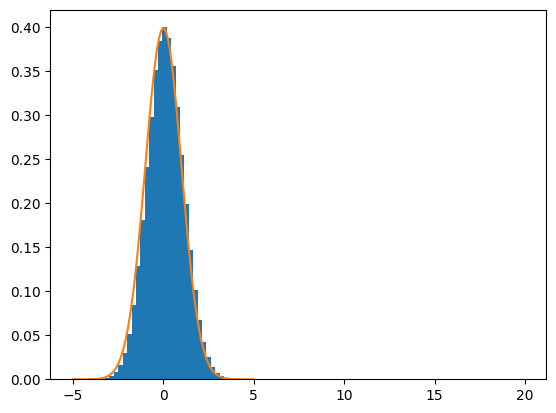

In [119]:
plt.hist(sigma[(hpmap_All != 0)],bins=100,density=True)
x=np.linspace(-5,5,100)
y = 1/np.sqrt(2*np.pi)*np.exp(-x**2/2)
plt.plot(x,y)
plt.show()

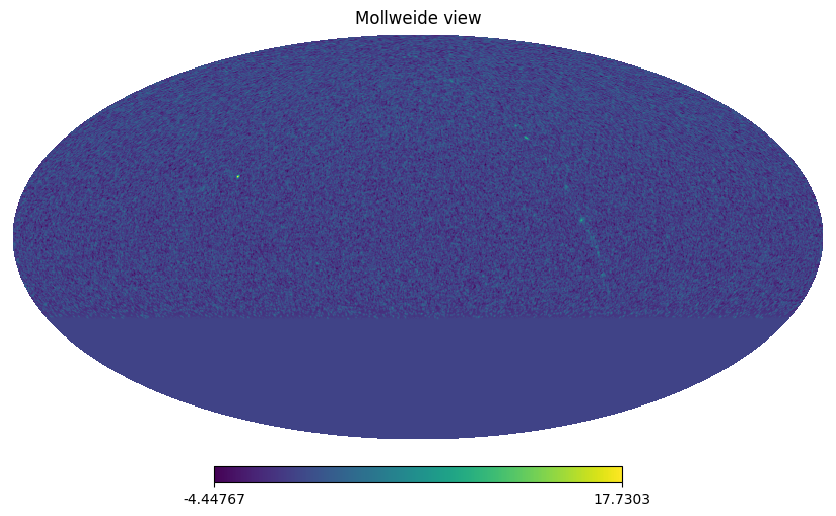

: 

In [120]:
hp.mollview(sigma)

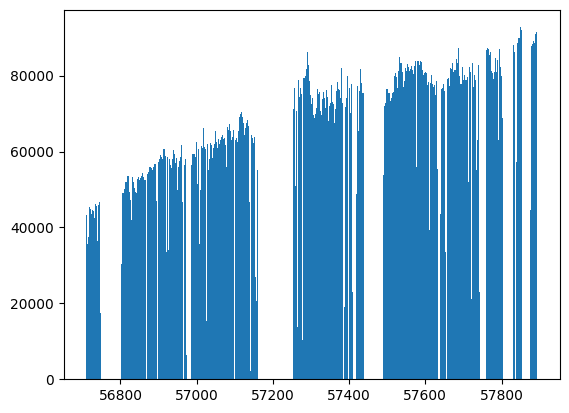

In [49]:
plt.hist(Exptdata["mjd"],bins=np.linspace(56710,57893,57893-56710+1))
plt.show()

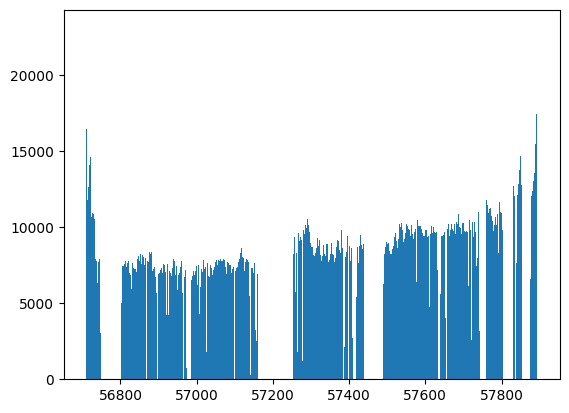

In [53]:
plt.hist(Exptdata["mjd"][Exptdata["isgamma_6"]>0.0035],bins=np.linspace(56710,57893,57893-56710+1))
plt.show()

In [98]:
sigma[sigma<4]=0

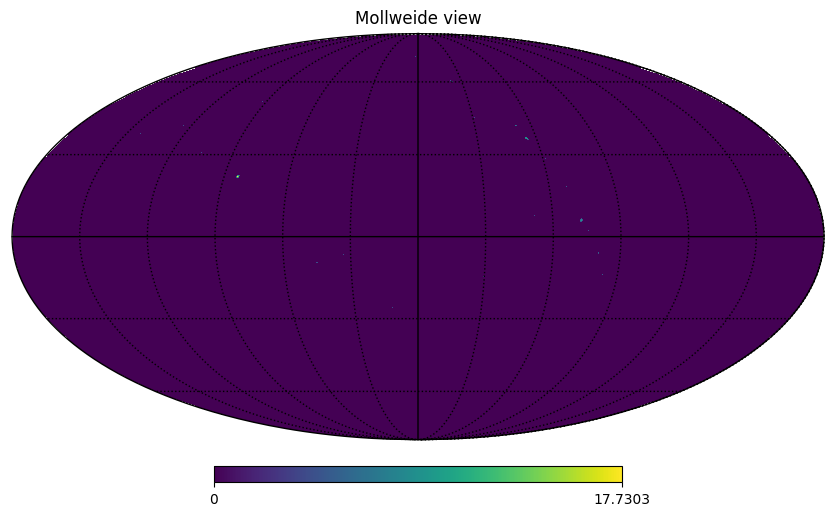

In [99]:
hp.mollview(sigma)
hp.graticule()

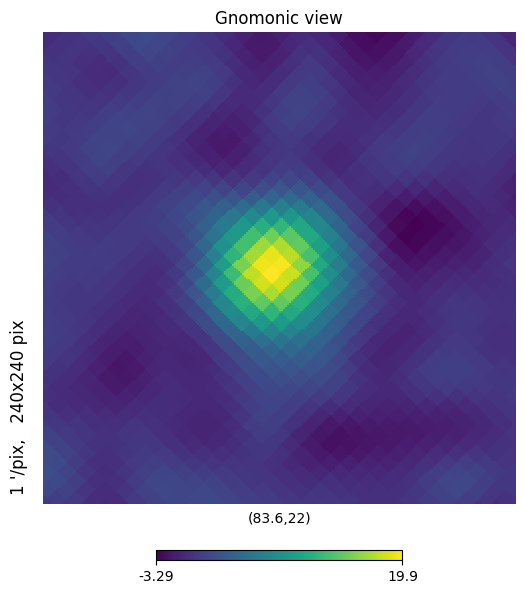

In [114]:
drawdeg = 2
reso = 1
hp.gnomview(
    sigma,
    rot=[83.6, 22],
    xsize=drawdeg * 60 / reso * 2,
    reso=reso,
)


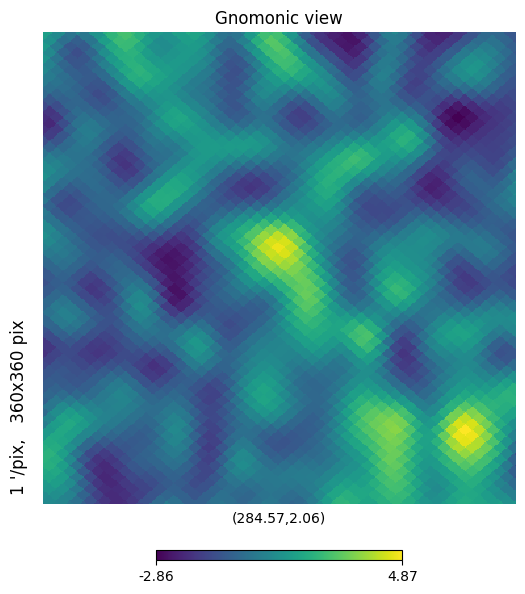

In [115]:
drawdeg = 3
reso = 1
hp.gnomview(
    sigma,
    rot=[284.57, 2.06],
    xsize=drawdeg * 60 / reso * 2,
    reso=reso,
)


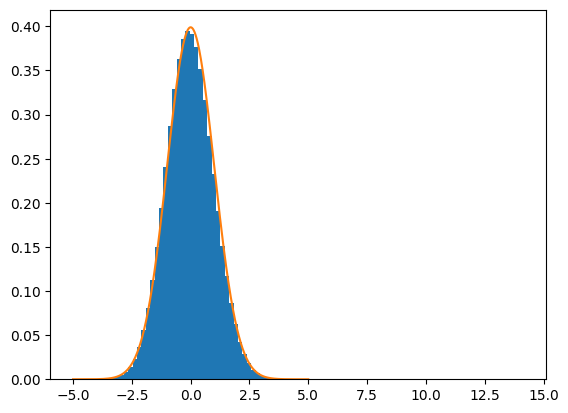

In [44]:
# hist,_=np.histogram(sigma[hpmap_All!=0],bins=100)
# sigma_gaus = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))
plt.hist(sigma[hpmap_All!=0],density=True,bins=100)
x=np.linspace(-5,5,1000)
y=1/np.sqrt(2*np.pi)*np.exp(-x**2/2)
plt.plot(x,y)
plt.show()

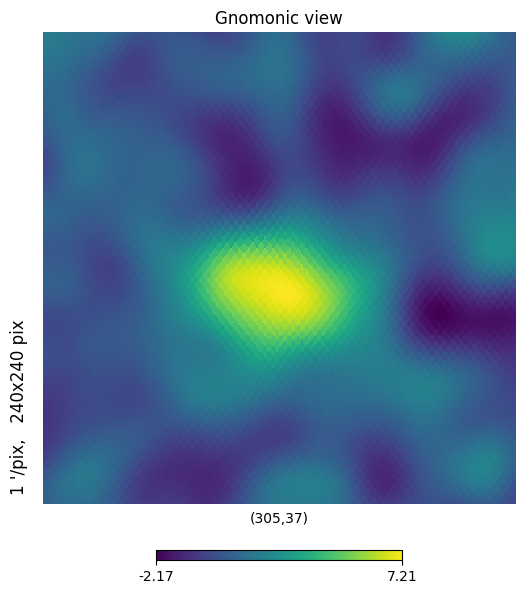

In [47]:
drawdeg = 2
reso = 1
hp.gnomview(
    sigma,
    rot=[305, 37],
    xsize=drawdeg * 60 / reso * 2,
    reso=reso,
)


In [40]:
hpmap_All_smoothed = np.zeros_like(hpmap_All)
hpmap_Background_smoothed = np.zeros_like(hpmap_All)
pixlenlist = list()
for i in range(NPIX):
    pix_need = hp.query_disc(NSIDE, hp.pix2vec(NSIDE, i), np.deg2rad(0.5))
    hpmap_All_smoothed[i] = np.sum(hpmap_All[pix_need])
    hpmap_Background_smoothed[i] = np.sum(hpmap_Background[pix_need])

In [18]:
len(Exptdata["sumpf"])

50093737

In [19]:
np.argmax(hpmap_All_smoothed)

625352

/tmp/ipykernel_6938/2013940310.py:3: RuntimeWarning: invalid value encountered in divide
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_6938/2013940310.py:3: RuntimeWarning: divide by zero encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_6938/2013940310.py:3: RuntimeWarning: invalid value encountered in multiply
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_6938/2013940310.py:4: RuntimeWarning: invalid value encountered in divide
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
/tmp/ipykernel_6938/2013940310.py:4: RuntimeWarning: divide by zero encountered in log
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
/tmp/ipykernel_6938/2013940310.py:4: RuntimeWarning: invalid value encountered in multiply
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))


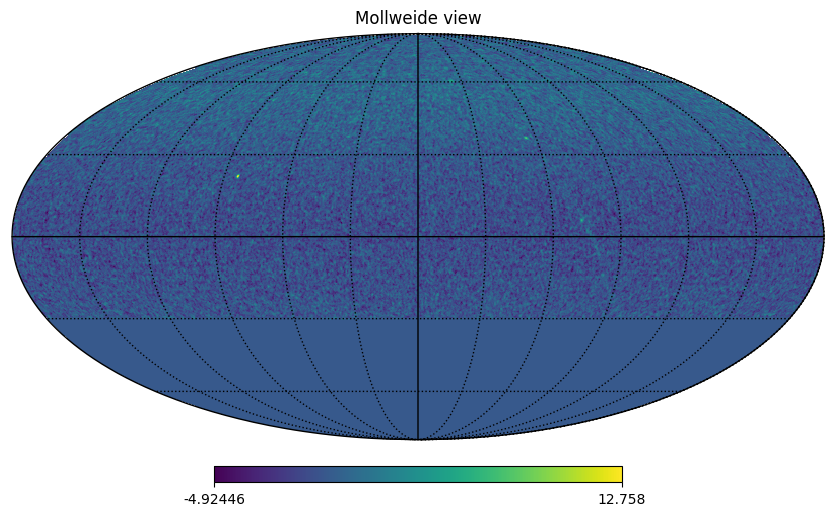

In [20]:
sigma=LIMA(0.05,hpmap_All_smoothed,hpmap_Background_smoothed)
hp.mollview(sigma)
hp.graticule()

In [21]:
np.argmax(hpmap_All_smoothed-hpmap_Background_smoothed/20)

978395

In [24]:
hp.pix2ang(NSIDE, np.argmax(hpmap_All_smoothed), lonlat=True)


(305.15625, 37.07533498237023)

In [11]:
arg=np.argmax(hpmap_All_smoothed-hpmap_Background_smoothed/20)

print("On:",hpmap_All_smoothed[arg])
print("Off:",hpmap_Background_smoothed[arg])
print("Over:",hpmap_All_smoothed[arg]-hpmap_Background_smoothed[arg]/20)

On: 2538.0
Off: 37432.0
Over: 666.4000000000001


/tmp/ipykernel_3334/2013940310.py:3: RuntimeWarning: invalid value encountered in divide
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_3334/2013940310.py:3: RuntimeWarning: divide by zero encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_3334/2013940310.py:3: RuntimeWarning: invalid value encountered in multiply
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_3334/2013940310.py:4: RuntimeWarning: invalid value encountered in divide
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
/tmp/ipykernel_3334/2013940310.py:4: RuntimeWarning: divide by zero encountered in log
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
/tmp/ipykernel_3334/2013940310.py:4: RuntimeWarning: invalid value encountered in multiply
  + Noff * np.log((1 + alpha) * Noff / (Non + Noff))


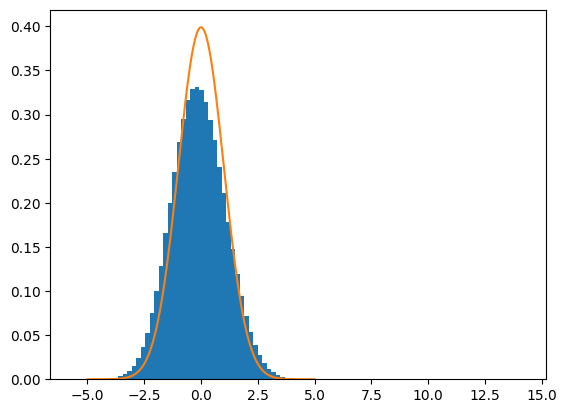

In [23]:
sigma=LIMA(0.05,hpmap_All_smoothed,hpmap_Background_smoothed)
plt.hist(sigma[hpmap_All!=0],density=True,bins=100)
x=np.linspace(-5,5,1000)
y=1/np.sqrt(2*np.pi)*np.exp(-x**2/2)
plt.plot(x,y)
plt.show()

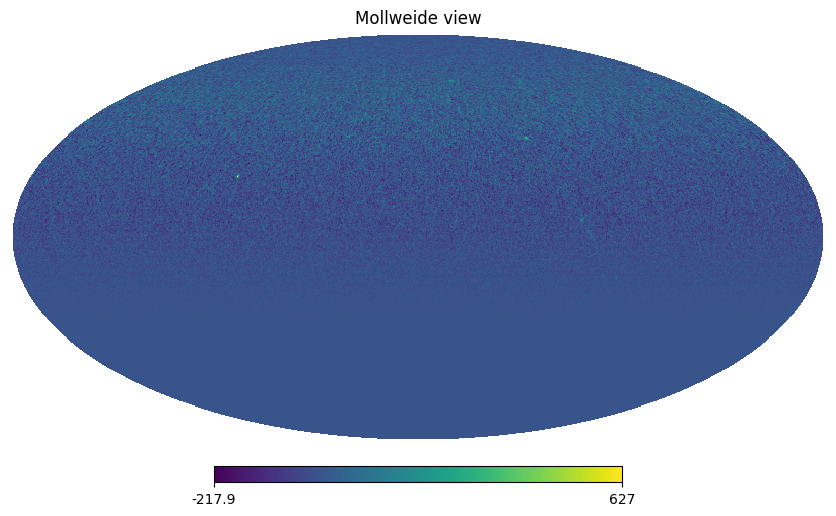

In [46]:
hp.mollview(hpmap_All_smoothed-hpmap_Background_smoothed/20)

In [46]:
import healpy as hp

NSIDE = 2**9
NPIX = hp.nside2npix(NSIDE)
for isgammamin in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    for energymin in [10, 25, 50, 100]:
        hpmap = np.zeros(NPIX)
        np.add.at(
            hpmap,
            hp.ang2pix(
                NSIDE,
                Exptdata["Ra"][
                    np.where(
                        (Exptdata["isgamma"] > isgammamin)
                        & (Exptdata["energy"] > energymin)
                    )
                ],
                Exptdata["Dec"][
                    np.where(
                        (Exptdata["isgamma"] > isgammamin)
                        & (Exptdata["energy"] > energymin)
                    )
                ],
                lonlat=True,
            ),
            1,
        )
        hpmap_smoothed = np.zeros(NPIX)
        pixlist = hp.query_strip(NSIDE, np.deg2rad(90 - 27), np.deg2rad(90 - 17))
        for i in pixlist:
            hpmap_smoothed[i] = np.sum(
                hpmap[hp.query_disc(NSIDE, hp.pix2vec(NSIDE, i), np.deg2rad(0.5))]
            )
        hpmap_smoothed_copy = hpmap_smoothed.copy()
        hpmap_smoothed_background = np.zeros_like(hpmap_smoothed)
        hpmap_smoothed_copy[
            hp.query_disc(NSIDE, hp.ang2vec(83.6, 22, lonlat=True), np.deg2rad(2))
        ] = 0
        sigma = np.zeros(NPIX)
        for theta in np.linspace(22 - 4, 22 + 4, 81):
            pix = hp.query_strip(
                NSIDE, np.deg2rad(90 - theta - 0.1), np.deg2rad(90 - theta)
            )
            # print(hpmap_smoothed_copy[pix][np.where(hpmap_smoothed_copy[pix]!=0)])
            hpmap_smoothed_background[pix] = np.mean(
                hpmap_smoothed_copy[pix][np.where(hpmap_smoothed_copy[pix] != 0)]
            )
            rate = 1 / len(pix)
            sigma[pix] = LIMA(
                rate,
                hpmap_smoothed[pix],
                hpmap_smoothed_background[pix] / rate,
            )
        sigma[np.isnan(sigma)] = 0
        hp.gnomview(
            sigma,
            rot=[83.6, 22],
            xsize=3 * 2 * 10,
            reso=6,
        )
        plt.title(
            f"gammacut:{isgammamin:.2f} energymin:{energymin} significant {np.max(sigma):.2f}$\sigma$"
        )
        plt.savefig(
            f"/home2/hky/github/Gamma_Energy/AllSky_withCR/fig/Crab/significant/{isgammamin:.2f}_{energymin}_{np.max(sigma):.2f}_significant.png"
        )
        plt.close()
        hp.gnomview(
            hpmap_smoothed - hpmap_smoothed_background,
            rot=[83.6, 22],
            xsize=3 * 2 * 10,
            reso=6,
        )
        plt.title(f"gammacut:{isgammamin:.2f} energymin:{energymin} over")
        plt.savefig(
            f"/home2/hky/github/Gamma_Energy/AllSky_withCR/fig/Crab/Over/{isgammamin:.2f}_{energymin}_Over.png"
        )
        plt.close()


/tmp/ipykernel_2075388/2091761696.py:3: RuntimeWarning: divide by zero encountered in log
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
/tmp/ipykernel_2075388/2091761696.py:3: RuntimeWarning: invalid value encountered in multiply
  Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))


In [9]:
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta) ** 2) / (2 * sigma_x**2) + (np.sin(theta) ** 2) / (
        2 * sigma_y**2
    )
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (
        4 * sigma_y**2
    )
    c = (np.sin(theta) ** 2) / (2 * sigma_x**2) + (np.cos(theta) ** 2) / (
        2 * sigma_y**2
    )
    g = offset + amplitude * np.exp(
        -(a * ((x - xo) ** 2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo) ** 2))
    )
    return g.ravel()


def twoD_gaussian_r(distance, sigma):
    return np.exp(-(distance**2) / 2 / sigma**2)

In [66]:
def GetAllBackground(
    Exptdata,
    Energymin,
    Ra,
    Ra_gap,
    Ra_bins,
    Dec,
    Dec_gap,
    Dec_bins,
    angle,
    energyname,
    method,
    fixangel,
):
    Ra_min = Ra - Ra_gap * Ra_bins / 2
    Ra_max = Ra + Ra_gap * Ra_bins / 2
    Dec_min = Dec - Dec_gap * Dec_bins / 2
    Dec_max = Dec + Dec_gap * Dec_bins / 2
    x_binscount = int(np.round((Ra_max - Ra_min) / Ra_gap)) + 1
    y_binscount = int(np.round((Dec_max - Dec_min) / Dec_gap)) + 1
    x_bins = np.linspace(Ra_min, Ra_max, x_binscount)
    y_bins = np.linspace(Dec_min, Dec_max, y_binscount)
    x = (x_bins[:-1] + x_bins[1:]) / 2
    y = (y_bins[:-1] + y_bins[1:]) / 2
    ALL = np.zeros([len(x), len(y), len(angle)])
    Background = np.zeros([len(x), len(y), len(angle)])
    Dec_outer = 2
    Ra_outer = 2 * np.rad2deg(
        np.arcsin(
            np.sin(np.deg2rad(Dec_outer / 2))
            / np.cos(np.deg2rad(np.max(np.abs([Dec_min, Dec_max]))))
        )
    )
    index_energy_cut = np.where(
        (Exptdata[f"energy_{energyname}"] > Energymin)
        & (Exptdata[f"Dec{fixangel}"] > Dec_min - Dec_outer)
        & (Exptdata[f"Dec{fixangel}"] < Dec_max + Dec_outer)
        & (Exptdata[f"Ra{fixangel}"] > Ra_min - Ra_outer)
        & (Exptdata[f"Ra{fixangel}"] < Ra_max + Ra_outer)
    )
    windowssize = getwindowssize(Exptdata["sumpf"], index_energy_cut, angle, 1, method)
    # print(windowssize)
    for i in range(x_binscount - 1):
        for j in range(y_binscount - 1):
            distance = twoPointAngle(
                90 - Exptdata[f"Dec{fixangel}"][index_energy_cut],
                90 - y[j],
                Exptdata[f"Ra{fixangel}"][index_energy_cut],
                x[i],
            )
            for minsize_i in range(len(angle)):
                if method == "gauss":
                    ALL[i, j, minsize_i] = np.sum(
                        twoD_gaussian_r(distance, angle[minsize_i])
                    )
                else:
                    # print(np.sum(distance < windowssize[minsize_i]))
                    ALL[i, j, minsize_i] = np.sum(distance < windowssize[minsize_i])

    for k in range(20):
        index_energy_cut = np.where(
            (Exptdata[f"energy_{energyname}"] > Energymin)
            & (Exptdata[f"DecOff{fixangel}_{k}"] > Dec_min - Dec_outer)
            & (Exptdata[f"DecOff{fixangel}_{k}"] < Dec_max + Dec_outer)
            & (Exptdata[f"RaOff{fixangel}_{k}"] > Ra_min - Ra_outer)
            & (Exptdata[f"RaOff{fixangel}_{k}"] < Ra_max + Ra_outer)
        )
        windowssize = getwindowssize(
            Exptdata["sumpf"], index_energy_cut, angle, 1, method
        )

        for i in range(x_binscount - 1):
            for j in range(y_binscount - 1):
                distance = twoPointAngle(
                    90 - Exptdata[f"DecOff{fixangel}_{k}"][index_energy_cut],
                    90 - y[j],
                    Exptdata[f"RaOff{fixangel}_{k}"][index_energy_cut],
                    x[i],
                )
                for minsize_i in range(len(angle)):
                    if method == "gauss":
                        Background[i, j, minsize_i] += np.sum(
                            twoD_gaussian_r(distance, angle[minsize_i])
                        )
                    else:
                        Background[i, j, minsize_i] += np.sum(
                            distance < windowssize[minsize_i]
                        )
    print(f"=====finish=======Ra={Ra}")
    return x, y, ALL, Background


def ALLBackground_dummy_Callback(result):
    ALL_dummy.append(result[2])
    Background_dummy.append(result[3])

In [68]:
angle=0.5
x, y, ALL, Background = GetAllBackground(
                        Exptdata,
                        Energymin,
                        Ra,
                        Ra_gap,
                        Ra_bins,
                        Dec,
                        Dec_gap,
                        Dec_bins,
                        [angle],
                        "hky",
                        "point",
                        "",
                    )

=====finish=======Ra=83.6


In [22]:
ALL_dummy = list()
Background_dummy = list()
pool = multiprocessing.Pool()
for i in range(35):
    # print(i)
    Ra += 10
    Ra = Ra % 360
    pool.apply_async(
        GetAllBackground,
        args=(
            Exptdata,
            Energymin,
            Ra,
            Ra_gap,
            Ra_bins,
            Dec,
            Dec_gap,
            Dec_bins,
            [angle],
            "hky",
            "point",
            "",
        ),
        callback=ALLBackground_dummy_Callback,
    )


In [72]:
ALL_tmp = ALL[:, :, 0].T
Background_tmp = Background[:, :, 0].T

In [73]:
sig = LIMA(0.05, ALL_tmp, Background_tmp)

In [70]:
sig[np.isnan(sig)] = 0

In [30]:
pool.close()
pool.join()

In [48]:
ALL_dummy = np.array(ALL_dummy)
Background_dummy = np.array(Background_dummy)
ALL_tmp_dummy = np.sum(ALL_dummy[:, :, :, 0], axis=0).T
Background_tmp_dummy = np.sum(Background_dummy[:, :, :, 0], axis=0).T


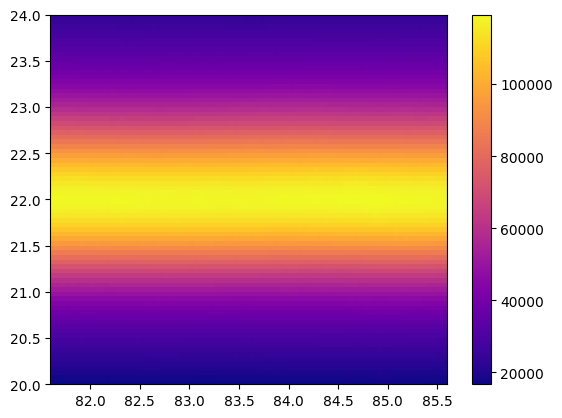

In [83]:
fig, axs = plt.subplots()
c = axs.pcolormesh(x, y, ALL_tmp_dummy, cmap="plasma")
fig.colorbar(c, orientation="vertical")


In [35]:
ALL_tmp

array([[538., 544., 543., ..., 480., 478., 479.],
       [572., 578., 578., ..., 512., 513., 509.],
       [611., 606., 605., ..., 538., 542., 540.],
       ...,
       [770., 780., 794., ..., 742., 729., 745.],
       [736., 744., 759., ..., 716., 708., 714.],
       [700., 712., 721., ..., 700., 692., 691.]])